# Encoding by pronouciation

## preparation

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sn
import re

In [2]:
import wn
from wn import morphy 
ewn = wn.Wordnet('ewn:2020')
m = morphy.Morphy(ewn)

In [48]:
from tqdm import tqdm

In [381]:
pronouncing_dict_path = './cmudict.dict.txt'

In [382]:
dico = {}
with open(pronouncing_dict_path, 'r', encoding='utf-8') as file:
	for line in file.readlines():
		line = re.sub('\d', '', line) # remove tone number
		l = line.strip().split(' ')
		word = l[0]
		pronounciation = ' '.join(l[1:])
		# filter some non standard words
		if word.islower() and word.isalpha():
			dico[word] = pronounciation

In [383]:
len(dico)

117490

first check if the word exists in wordnet

In [384]:
def validate(word):
	# check if exists
	res = wn.synsets(word)
	if res != []:
		return True
	# otherwise check if as a derivation, the lemma exists
	for lemmas_per_pos in m(word).values():
		for lemma in lemmas_per_pos:
			res = wn.synsets(lemma)
			# if there exists one, return
			if res != []:
				return True
	return False

In [ ]:
non_words = []
for word in tqdm(dico.keys()):
	if not validate(word):
		non_words.append(word)

In [386]:
len(non_words)

1

In [ ]:
with open('./non_wordnet_words.txt', 'w', encoding='utf-8') as file:
	for non_word in non_words:
		file.write(non_word+'\n')

However, wordnet excludes some function words, they should be taken into account in dictionary

In [387]:
with open('./non_wordnet_words.txt', 'r', encoding='utf-8') as file:
	non_words = file.read().splitlines()

In [388]:
with open('./wordnet_stopwords.txt', 'r', encoding='utf-8') as file:
	stop_words = file.read().splitlines()

In [389]:
for non_word in non_words:
	if not non_word in stop_words:
		dico.pop(non_word)

In [390]:
len(dico)

52123

Notice that many of them are acronyms, which is pronounced as individual letters, we could remove them directly from the cmu dict, the acronyms will be dealed in another independent dico.

## Remove acronyms

first collect single letter sound

In [391]:
letter_sound = {}
syllable_count = {}
for word, sound in dico.items():
	if len(word) == 1:
		letter_sound[word] = list(sound.split(' '))
		syllable_count[word] = len(sound.split(' '))

In [392]:
letter_sound['a'] = ['EY'] # A sounds EY1 not AH0

In [393]:
letter_sound, syllable_count

({'a': ['EY'],
  'b': ['B', 'IY'],
  'c': ['S', 'IY'],
  'd': ['D', 'IY'],
  'e': ['IY'],
  'f': ['EH', 'F'],
  'g': ['JH', 'IY'],
  'h': ['EY', 'CH'],
  'i': ['AY'],
  'j': ['JH', 'EY'],
  'k': ['K', 'EY'],
  'l': ['EH', 'L'],
  'm': ['EH', 'M'],
  'n': ['EH', 'N'],
  'o': ['OW'],
  'p': ['P', 'IY'],
  'q': ['K', 'Y', 'UW'],
  'r': ['AA', 'R'],
  's': ['EH', 'S'],
  't': ['T', 'IY'],
  'u': ['Y', 'UW'],
  'v': ['V', 'IY'],
  'w': ['D', 'AH', 'B', 'AH', 'L', 'Y', 'UW'],
  'x': ['EH', 'K', 'S'],
  'y': ['W', 'AY'],
  'z': ['Z', 'IY']},
 {'a': 1,
  'b': 2,
  'c': 2,
  'd': 2,
  'e': 1,
  'f': 2,
  'g': 2,
  'h': 2,
  'i': 1,
  'j': 2,
  'k': 2,
  'l': 2,
  'm': 2,
  'n': 2,
  'o': 1,
  'p': 2,
  'q': 3,
  'r': 2,
  's': 2,
  't': 2,
  'u': 2,
  'v': 2,
  'w': 7,
  'x': 3,
  'y': 2,
  'z': 2})

In [394]:
def is_acronym(word, sound, threshold=2, show = False):
	matched = 0
	offset = 0
	sound_list = sound.split(' ')
	for letter in word:
		step = syllable_count[letter]
		if show:
			print(letter_sound[letter])
			print(sound_list[offset:offset+step])

		if letter_sound[letter] == sound_list[offset:offset+step]:
			matched += 1
		if matched >= threshold:
			return True
		offset += step
	return False

In [395]:
is_acronym('abc',dico['abc']), is_acronym('good', dico['good']), is_acronym('aardvark', dico['aardvark'], show=True)

['EY']
['AA']
['EY']
['R']
['AA', 'R']
['D', 'V']
['D', 'IY']
['AA', 'R']
['V', 'IY']
['K']
['EY']
[]
['AA', 'R']
[]
['K', 'EY']
[]


(True, False, False)

In [396]:
acronyms = []
for (word, sound) in dico.items():
	if len(word) > 4:
		continue
	if is_acronym(word, sound, 2):
		acronyms.append(word)

In [397]:
len(acronyms)

114

In [398]:
for word in acronyms:
	dico.pop(word)

In [399]:
dico.pop('aaa')

'T R IH P AH L EY'

In [400]:
len(dico)

52008

now we get a well pronounced, wordnet-validated dictionary

In [401]:
df = pd.DataFrame.from_dict(dico, orient='index', columns = ['sound'])

In [402]:
df_freq = pd.read_csv('./dict_freq_en.yaml', sep = '\t', index_col=0, usecols=[1,2])
df_freq

,COUNT
WORD,
the,4888
of,4883
and,4878
to,4873
in,4868
...,...
bepride,0
batterable,0
batsome,0


In [403]:
df = df.join(df_freq.astype('Int64'))

In [404]:
df.index.name = 'word'

In [405]:
df.rename(columns={'COUNT': 'freq'}, inplace=True)

In [406]:
df

,sound,freq
word,,
a,AH,4863
aachen,AA K AH N,<NA>
aalborg,AO L B AO R G,<NA>
aalto,AA L T OW,<NA>
aardvark,AA R D V AA R K,<NA>
...,...,...
zuni,Z UW N IY,<NA>
zurich,Z UH R IH K,<NA>
zweig,Z W AY G,<NA>


## Transcription

In [108]:
def encode(phonemes):
	vowels = re.compile('(AO|UW|EH|AH|AA|IY|IH|UH|AE|AW|AY|ER|EY|OW|OY)\d*', re.VERBOSE)
	phonemes = re.sub(vowels, 'Q', phonemes)
	complex_consonant = re.compile('CH|DH|HH|JH|NG|SH|TH|ZH|')
	# complex consonants
	phonemes = re.sub('HH', 'H', phonemes)
	phonemes = re.sub('CH', 'C', phonemes)
	phonemes = re.sub('JH', 'J', phonemes)
	phonemes = re.sub('TH', 'X', phonemes)
	phonemes = re.sub('DH', 'X', phonemes)
	phonemes = re.sub('SH', 'U', phonemes)
	phonemes = re.sub('ZH', 'O', phonemes)
	phonemes = re.sub('NG', 'I', phonemes)
	
	# remove whitespaces
	phonemes = re.sub(' ', '', phonemes)

	return phonemes

In [109]:
def transcribe(phonemes_list):
	encoding_list = []
	for phonemes in phonemes_list:
		encoding_list.append(encode(phonemes))
	return encoding_list

In [110]:
encoding_list = transcribe(df.sound.astype('str'))
df['encoding'] = encoding_list

In [111]:
df

,sound,freq,encoding,vowel_free
word,,,,
a,AH,4863,Q,A
aachen,AA K AH N,,QKQN,QKN
aalborg,AO L B AO R G,,QLBQRG,QLBRG
aalto,AA L T OW,,QLTQ,QLTQ
aardvark,AA R D V AA R K,,QRDVQRK,QRDVRK
...,...,...,...,...
zuni,Z UW N IY,,ZQNQ,ZNQ
zurich,Z UH R IH K,,ZQRQK,ZRK
zweig,Z W AY G,,ZWQG,ZWG


## delete non-initial vowels

In [153]:
def remove_vowels(encoding_list):
	res = []
	for encoding in encoding_list:
		if len(encoding) > 1:
			res.append(encoding[0] + re.sub('Q','', encoding[1:-1]) + encoding[-1])
		else:
			res.append(encoding)
	return res

## Detect inefficient encoding

In [420]:
df['vowel_free'] = remove_vowels(df.encoding) 

In [421]:
# with pd.option_context('display.max_rows', None):
acronym_residue = df.loc[(df.index.str.len() > 1) & (df.index.str.len() <= 4) & (df.index.str.len() < df.vowel_free.str.len()) & (~df.freq.notna()), ['sound','encoding','vowel_free','freq']]
display(acronym_residue)

,sound,encoding,vowel_free,freq
word,,,,
aug,AO G AH S T,QGQST,QGST,<NA>
ct,K AO R T,KQRT,KRT,<NA>
emu,IY M Y UW,QMYQ,QMYQ,<NA>
expo,EH K S P OW,QKSPQ,QKSPQ,<NA>
feb,F EH B Y AH W EH R IY,FQBYQWQRQ,FBYWRQ,<NA>
hz,HH ER T Z,HQTZ,HTZ,<NA>
jr,JH UW N Y ER,JQNYQ,JNYQ,<NA>
lb,P AW N D,PQND,PND,<NA>
lbs,P AW N D Z,PQNDS,PNDS,<NA>


In [422]:
df.drop(acronym_residue.index, inplace=True)

In [423]:
len(df)

51993

Notice that many of them are acronyms, which is pronounced as individual letters, we could remove them directly from the cmu dict, the acronyms will be dealed in another independent dico.

In [426]:
df

,sound,freq,encoding,vowel_free
word,,,,
a,AH,4863,Q,Q
aachen,AA K AH N,<NA>,QKQN,QKN
aalborg,AO L B AO R G,<NA>,QLBQRG,QLBRG
aalto,AA L T OW,<NA>,QLTQ,QLTQ
aardvark,AA R D V AA R K,<NA>,QRDVQRK,QRDVRK
...,...,...,...,...
zuni,Z UW N IY,<NA>,ZQNQ,ZNQ
zurich,Z UH R IH K,<NA>,ZQRQK,ZRK
zweig,Z W AY G,<NA>,ZWQG,ZWG


In [427]:
df.loc['abbreviated']

sound         AH B R IY V IY EY T IH D
freq                                50
encoding                    QBRQVQQTQE
vowel_free                      QBRVTE
Name: abbreviated, dtype: object

## Encoding Statistics

encoding length

In [165]:
def plot_string_length_freq(encodings: pd.DataFrame):
	wd_length = encodings.reset_index().apply(lambda x: x.str.len(), axis=0).astype(pd.Int64Dtype())
	display(wd_length.describe(percentiles=[.9,.95,.99]).drop(['count','50%','min']))

	wd_length_count = wd_length.melt()
	wd_length_count = wd_length_count.pivot_table(index='value', columns='variable', values='value', aggfunc='size')
	plt.style.use('seaborn-v0_8-notebook')
	wd_length_count.plot(kind='bar')
	

- less average encoding length: lazier
- less standard deviation of encoding length: evener

In [ ]:
plot_string_length_freq(df[['encoding', 'vowel_free']])

coincident codes: counts of words with same encoding

In [ ]:
def coincident_stats(encodings: pd.DataFrame, ext = 10):
	total = len(encodings)

	multiplicity = encodings.value_counts()
	multiplicity.index.name = 'encoding'
	multiplicity.name = 'multiplicity'

	multiplicity_freq = multiplicity.value_counts()
	multiplicity_freq.index.name = 'multiplicity'
	multiplicity_freq.name = 'freq'

	coincident_rate = 1 - (multiplicity_freq.loc[1]) / multiplicity_freq.sum()

	extremes = multiplicity_freq.loc[ext+1:]
	word_count_with_extreme_encodings = (extremes.index.to_numpy() * extremes.values).sum()
	ratio_with_extreme_encodings = np.round( word_count_with_extreme_encodings/total *100 , 2)

	print(f'coincident_rate: {np.round(coincident_rate * 100,2)}%')
	print(f'There are {extremes.sum()} encodings have more than {ext} multiplicities, encoding {word_count_with_extreme_encodings}({ratio_with_extreme_encodings}%) words.')

	q = multiplicity.quantile([.8,.9,.95,.99])
	q.index.name = 'quantile'
	q.name = 'multiplicity'

	print('extreme:')
	display(extremes.to_frame())
	print('quantile:')
	display(q.to_frame())

	extreme_encoding = pd.Series(multiplicity[multiplicity > ext].index)
	extreme_encoding.name = 'freq'
	extreme_encoding.index.name = 'encoding_length'
	if len(extreme_encoding) > 0:
		# display(extreme_encoding)
		sn.barplot(x = extreme_encoding.str.len().value_counts().index, y = extreme_encoding.str.len().value_counts())
	# plt.hist(multiplicity,bins=range(min(multiplicity), max(multiplicity)+1,1))
	return multiplicity, multiplicity_freq, extreme_encoding

no coincidence in original dictionary lexicon(of course)

In [ ]:
_ = coincident_stats(df.index)

In [ ]:
_ = coincident_stats(df.encoding)

In [ ]:
multiplicity, _, extreme_encoding = coincident_stats(df.vowel_free)

let's taker a careful look at the extreme encodings

In [ ]:
extreme_encoding

In [ ]:
multiplicity[multiplicity > 10]

In [ ]:
with pd.option_context('display.max_rows', None, 'display.max_columns', None):
	display(multiplicity[multiplicity > 10])
	display(df[df.vowel_free.isin(['BLS','FLS'])])

## Normalization

We hope that:
1. the plurals and the third person single form are uniformly terminated with S(instead of Z)
2. the past particles are uniformly terminated with E(instead of T or D)
3. the present particles are uniformly terminated with I(this is already done since we encode NG sound by I)

you can take these terminations as a grammatical symbol

In [112]:
df.encoding.loc[(df.index.str.contains('s$', regex=True) == True)]

word
aardvarks           QRDVQRKS
aarhus                  QHQS
abacus                QBQKQS
abalones            QBQLQNQZ
abandonments    QBQNDQNMQNTS
                    ...     
zones                   ZQNZ
zoologists        ZQQLQJQSTS
zooms                   ZQMZ
zoos                     ZQZ
zucchinis            ZQKQNQZ
Name: encoding, Length: 13296, dtype: object

In [113]:
df.encoding.loc[(df.index.str.contains('ed$', regex=True) == True)]

word
abandoned        QBQNDQND
abashed             QBQUT
abated             QBQTQD
abbreviated    QBRQVQQTQD
abdicated       QBDQKQTQD
                  ...    
zigzagged         ZQGZQGD
zipped               ZQPT
zippered            ZQPQD
zoned                ZQND
zoomed               ZQMD
Name: encoding, Length: 4701, dtype: object

In [114]:
df.encoding.loc[(df.index.str.contains('ing$', regex=True) == True)]

word
abandoning       QBQNDQNQI
abating             QBQTQI
abbreviating    QBRQVQQTQI
abdicating       QBDQKQTQI
abducting         QBDQKTQI
                   ...    
zing                   ZQI
zippering          ZQPQRQI
zipping              ZQPQI
zoning               ZQNQI
zooming              ZQMQI
Name: encoding, Length: 4323, dtype: object

### Normalize S-form

notice that most of the extreme encodings have the `S` termination, which is due to enormous derivations in plurals/single third person form (we call them S-form). So it's better to spare another grammatical termination for them.

To do so, we must first recognize the S-form, there are two necessary criterion (yet not proved to be sufficient, perhaps some risks of mis-recognize?)

1. phonetic criterion: end with s|z
2. morphological criterion: word differs its lemma by s(es,ies et etc)

notice that we don't account for irregular words.


In [115]:
words_sound_end_with_s = df.loc[df.index.str.contains('s$',regex=True) & df.sound.str.contains('[SZ]$',regex=True)].index
words_sound_end_with_s

Index(['aardvarks', 'aarhus', 'abacus', 'abalones', 'abandonments', 'abandons',
       'abatements', 'abates', 'abbreviates', 'abbreviations',
       ...
       'zirconiums', 'zircons', 'zithers', 'zlotys', 'zombies', 'zones',
       'zoologists', 'zooms', 'zoos', 'zucchinis'],
      dtype='object', name='word', length=13272)

In [116]:
def get_suffix(word, lemma):
    cnt = sum(w==l for w, l in zip(word, lemma))
    return word[cnt:]

In [117]:
def is_s_form(word, non_s_forms: list):
	for lemmas_per_pos in m(word).values():
		for lemma in lemmas_per_pos:
			suffix = get_suffix(word, lemma)
			if suffix in ['s','es','ies', 'ves', 'ces', 'ses', 'ices', 'zes']:
			# if 's' in suffix :
				return True
	non_s_forms.append(word)

In [118]:
non_s_forms = []
for word in tqdm(words_sound_end_with_s):
	is_s_form(word, non_s_forms)

100%|██████████| 13272/13272 [00:00<00:00, 31704.99it/s]


In [119]:
len(non_s_forms)

1820

some rare s-forms we exclude them

In [121]:
m('pontes')

{'n': {'pons'}}

simple verification

In [123]:
'produces' in non_s_forms, 'bliss' in non_s_forms

(False, True)

In [124]:
s_form_candidates = words_sound_end_with_s.to_list()
for word in non_s_forms:
	s_form_candidates.remove(word)

s_forms = pd.Index(s_form_candidates)

In [125]:
s_forms

Index(['aardvarks', 'abalones', 'abandonments', 'abandons', 'abatements',
       'abates', 'abbreviates', 'abbreviations', 'abdicates', 'abductions',
       ...
       'zirconiums', 'zircons', 'zithers', 'zlotys', 'zombies', 'zones',
       'zoologists', 'zooms', 'zoos', 'zucchinis'],
      dtype='object', length=11452)

reencoding s-forms by `A`-termination

In [128]:
df.loc[s_forms, 'encoding'] = df.loc[s_forms, 'encoding'].str.replace('[SZ]$', 'A', regex=True)

In [129]:
df.loc[s_forms, 'encoding']

aardvarks           QRDVQRKA
abalones            QBQLQNQA
abandonments    QBQNDQNMQNTA
abandons            QBQNDQNA
abatements         QBQTMQNTA
                    ...     
zones                   ZQNA
zoologists        ZQQLQJQSTA
zooms                   ZQMA
zoos                     ZQA
zucchinis            ZQKQNQA
Name: encoding, Length: 11452, dtype: object

### Normalize past particle

words terminates with `-ed` consists also a large part of english vocabulary. Likewise, we need to recognize the past particle from all `-ed` form. The criterion is:

1. phonetic criterion: end with t|d
2. morphological criterion: word differs its lemma by ed(or d)

In [130]:
words_sound_end_with_t_or_d = df.loc[df.index.str.contains('ed$',regex=True) & df.sound.str.contains('[TD]$',regex=True)].index
words_sound_end_with_t_or_d

Index(['abandoned', 'abashed', 'abated', 'abbreviated', 'abdicated',
       'abducted', 'abed', 'abetted', 'abhorred', 'abided',
       ...
       'yielded', 'yoked', 'zapped', 'zed', 'zeroed', 'zigzagged', 'zipped',
       'zippered', 'zoned', 'zoomed'],
      dtype='object', name='word', length=4701)

In [140]:
def is_past_particle(word, non_past_particles: list):
	for lemmas_per_pos in m(word).values():
		for lemma in lemmas_per_pos:
			suffix = get_suffix(word, lemma)
			if 'd' in suffix:
				return True
	non_past_particles.append(word)

In [132]:
m('feed','v'), m('need','v')

({'v': {'fee', 'feed'}}, {'v': {'need'}})

In [141]:
non_past_particles = []
for word in tqdm(words_sound_end_with_t_or_d):
	is_past_particle(word, non_past_particles)

100%|██████████| 4701/4701 [00:00<00:00, 25226.03it/s]


In [142]:
len(non_past_particles)

446

In [143]:
'embed' in non_past_particles

True

In [146]:
'feed' in non_past_particles

False

some common word may be the past particle of a rare word, e.g. `fee-feed`, so there are some particular case need to be treated separately.

In [147]:
non_past_particles.append('feed')

reencoding past particle by 'E'-termination

In [149]:
past_particle_candidate = words_sound_end_with_t_or_d.to_list()
for word in  non_past_particles:
	past_particle_candidate.remove(word)

past_particles = pd.Index(past_particle_candidate)

In [150]:
past_particles

Index(['abandoned', 'abashed', 'abated', 'abbreviated', 'abdicated',
       'abducted', 'abetted', 'abhorred', 'abided', 'abolished',
       ...
       'yelped', 'yielded', 'yoked', 'zapped', 'zeroed', 'zigzagged', 'zipped',
       'zippered', 'zoned', 'zoomed'],
      dtype='object', length=4254)

In [151]:
df.loc[past_particles, 'encoding'] = df.loc[past_particles, 'encoding'].str.replace('[TD]$', 'E', regex=True)

In [154]:
df['vowel_free'] = remove_vowels(df.encoding)

In [155]:
df['vowel_free']

word
a                Q
aachen         QKN
aalborg      QLBRG
aalto         QLTQ
aardvark    QRDVRK
             ...  
zuni           ZNQ
zurich         ZRK
zweig          ZWG
zydeco        ZDKQ
zygote         ZGT
Name: vowel_free, Length: 51950, dtype: object

## Manually correct exceptions

Type letters, 2-grams, 3-grams by themselve  

In [158]:
df.loc['hi']

sound         HH AY
freq               
encoding         HQ
vowel_free       HQ
Name: hi, dtype: object

In [159]:
rare_2_grams =  df.loc[(df.index.str.len() == 2) & (~df.freq.notna()), ['encoding','freq']].drop('hi')

In [443]:
df.drop(rare_2_grams.index, inplace=True)

In [163]:
df.loc[(df.index.str.len() <= 3), 'vowel_free'] = df.index[(df.index.str.len() <= 3)].str.upper()

### reexaminate stats

,word,encoding,vowel_free
mean,7.930279,6.837421,4.642964
std,2.452292,2.371894,1.509648
90%,11.0,10.0,7.0
95%,12.0,11.0,7.0
99%,14.0,13.0,9.0
max,20.0,18.0,12.0


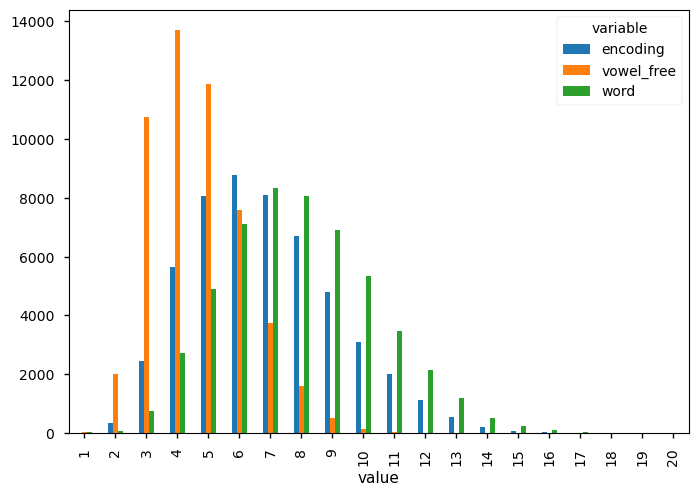

In [166]:
plot_string_length_freq(df[['encoding', 'vowel_free']])

coincident_rate: 18.0%
There are 269 encodings have more than 10 multiplicities, encoding 3634(7.0%) words.
extreme:


,freq
multiplicity,
11,53
10,52
12,40
14,30
13,29
15,18
16,10
17,6
18,5


quantile:


,multiplicity
quantile,
0.80,1.0
0.90,2.0
0.95,3.0
0.99,8.0


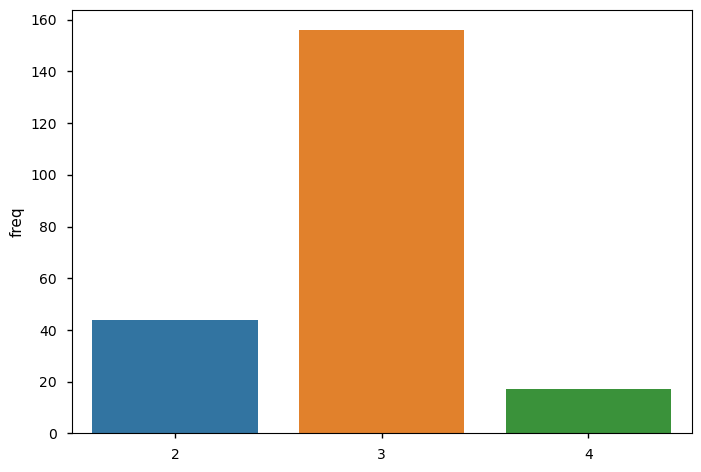

In [446]:
multiplicity, _, extreme_encoding = coincident_stats(df.vowel_free)

In [447]:
extreme_encoding

encoding_length
0       FLQ
1       FLA
2       BRQ
3       BLA
4       KLQ
       ... 
212    PRTQ
213     SKL
214     PLI
215     STI
216     KRT
Name: freq, Length: 217, dtype: object

In [448]:
multiplicity[multiplicity > 10]

encoding
FLQ     35
FLA     34
BRQ     33
BLA     32
KLQ     31
        ..
PRTQ    11
SKL     11
PLI     11
STI     11
KRT     11
Name: multiplicity, Length: 217, dtype: int64

In [167]:
df.to_csv('./dict_en.csv')

In [13]:
df= pd.read_csv('./dict_en.csv', sep = ',', index_col=0)

In [14]:
df.head()

,sound,freq,encoding,vowel_free
word,,,,
a,AH,4863.0,Q,A
aachen,AA K AH N,NaN,QKQN,QKN
aalborg,AO L B AO R G,NaN,QLBQRG,QLBRG
aalto,AA L T OW,NaN,QLTQ,QLTQ
aardvark,AA R D V AA R K,NaN,QRDVQRK,QRDVRK


In [15]:
df.vowel_free = df.vowel_free.str.lower()

In [168]:
df.loc[:,['vowel_free','freq']].to_csv('./dict_en.yaml', sep ='\t')

### Convenient abbr for common words use

In [458]:
with pd.option_context('display.max_rows', None):
	display(df.loc[(df.freq > 2000) &(df.index.str.len() <=4) & (df.vowel_free.str.len() > 2)])

,sound,freq,encoding,vowel_free
word,,,,
able,EY B AH L,2940,QBQL,QBL
age,EY JH,3253,QJ,AGE
air,EH R,3492,QR,AIR
all,AO L,4718,QL,ALL
also,AO L S OW,4553,QLSQ,QLSQ
and,AH N D,4878,QND,AND
any,EH N IY,4613,QNQ,ANY
are,AA R,4788,QR,ARE
area,EH R IY AH,3820,QRQQ,QRQ


### Further reductions:

continue reducing the encoding length and the multiplicity (although sometimes we need to trade off between these two objectives)

This will be accounted for lazy/fuzzy pronounciation and be implemented by the users and not directly in the encoding.

For example we can reduce approximants whose property can be considered as an interpolation between a vowel and a consonant. Sometimes it's not easy to tell them from a continuous speech flow and usually omitted by lazy speakers.

There are several phonological circumstances for approximants in English:
`A` for approximant, `C` for consonant, `V` for vowel

1. At the beginning `A-V` (`A-C` is not possible)
2. At the end `-A`
3. `V-A-C`
4. `V-A-V`
5. `C-A-V`

- for semi-vowels `Y,W`, we identify the following circumstances as reducable: 2, 3, 4, 5
- for approximant `R,L`, we identify the following circumstances as reducable: 2, 3

and even more radical reduction: e.g. nasal elision
- for nasal `M,N,NG`: 2, 3(condition to certain trailing consonant)
